In [3]:
import glob
import math
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from fbprophet import Prophet
from sklearn import neighbors, ensemble, tree, metrics
from statsmodels.graphics import tsaplots
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.seasonal import *

%matplotlib notebook

package_dir = os.getcwd()

print(package_dir)

C:\Users\Sebastian\Programming\Bachelorthtesis


In [ ]:
df = pd.DataFrame()

print('Loading CSVs\n')
for file in glob.glob('res/*.csv'):
    # read single file, index on StationEoI and DatetimeEnd
    read = pd.read_csv(file,
                 encoding="utf-16", parse_dates=[13, 14],
                 infer_datetime_format=True,
                 index_col=[4, 14])
    # drop 'bulk' files because they have different averaging
    bulks = read.SamplingPoint.str.lower().str.contains('bulk')
    clean = read[~bulks].copy()
    
    # ignore unnecessary columns
    clean.drop(columns=['Countrycode', 'Namespace', 'AirQualityNetwork',
                 'AirQualityStation', 'SamplingPoint', 'Sample',
                 'SamplingProcess', 'AirPollutantCode',
                 'DatetimeBegin', 'Validity', 'Verification',
                 'AveragingTime'],
        inplace=True)
    
    # make pollutant a column for better memory usage
    clean = clean.pivot(columns='AirPollutant')
    df = pd.concat([df, clean])

print('\nFinished Loading')
print('Merging')

# make names shorter    
df.index.names = ['StationEoI', 'Timestamp']
df.columns.names = [None, 'Pollutant']
df = df.sort_index()
df = df.groupby(level=[0,1]).first()


print('Finished merging')

In [2]:
df = pd.DataFrame()

for file in glob.glob('res/*2013_timeseries.csv'):
    # read single file, index on StationEoI and DatetimeEnd
    read = pd.read_csv(file,
                 encoding="utf-16", parse_dates=[13, 14],
                 infer_datetime_format=True,
                 index_col=[4,14])
    # drop 'bulk' files because they have different averaging
    bulks = read.SamplingPoint.str.lower().str.contains('bulk')
    clean = read[~bulks].copy()
    
    # ignore unnecessary columns
    clean.drop(columns=['Countrycode', 'Namespace', 'AirQualityNetwork',
                 'AirQualityStation', 'SamplingPoint', 'Sample',
                 'SamplingProcess', 'AirPollutantCode',
                 'DatetimeBegin', 'Validity', 'Verification',
                 'AveragingTime'],
        inplace=True)
    
    pivoted = clean.pivot(columns='AirPollutant')
    
    df = pd.concat([df, pivoted])

# make pollutant a column for better memory usage
#df = df.pivot(columns='AirPollutant')

# make names shorter    
df.index.names = ['StationEoI', 'Timestamp']
df.columns.names = [None, 'Pollutant']

df = df.sort_index()
df = df.groupby(level=[0,1]).first()

df = df.interpolate()

In [ ]:
df.loc['DESN025'].Concentration.count()

<IPython.core.display.Javascript object>


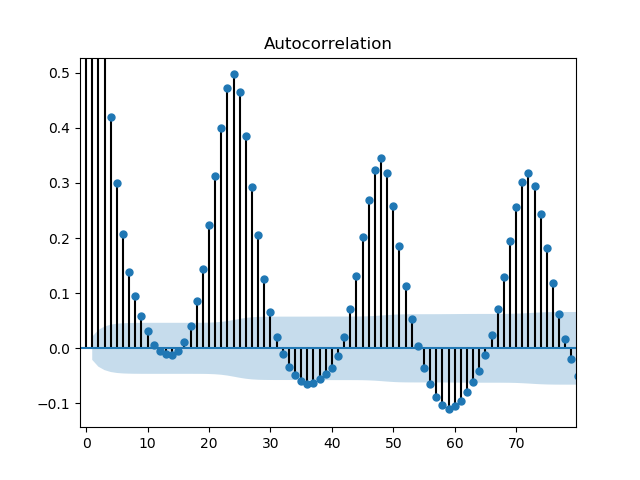

In [7]:
acf = tsaplots.plot_acf(df.loc['DESN025'].Concentration.NO, lags=700)

In [ ]:
plt.figure(figsize=(9, 4))

pd.plotting.autocorrelation_plot(df.loc['DESN025'].Concentration.NO)
plt.show()

<IPython.core.display.Javascript object>


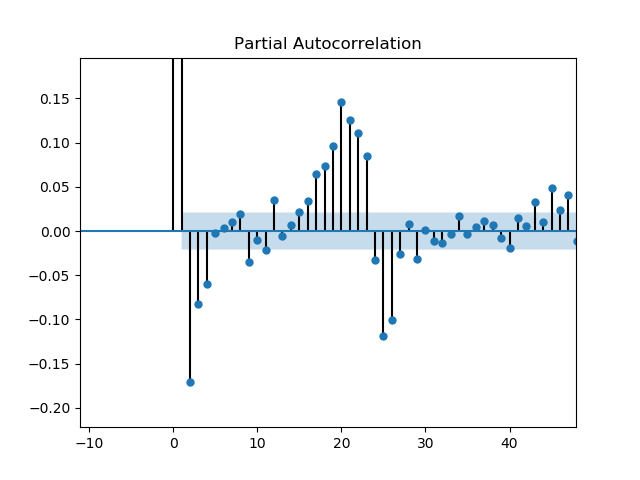

In [8]:
pacf = tsaplots.plot_pacf(df.loc['DESN025'].Concentration.NO, lags=700)

In [19]:
lagged = pd.DataFrame()

for i in range(1,8):
    lagged['lag {0}d'.format(i)] = df.loc['DESN025'].Concentration.NO.shift(i, freq='H')
    
lagged = lagged.interpolate()

lagged

,lag 1d,lag 2d,lag 3d,lag 4d,lag 5d,lag 6d,lag 7d
Timestamp,,,,,,,
2013-01-01 01:00:00,36.848,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-01 02:00:00,42.785,36.848,NaN,NaN,NaN,NaN,NaN
2013-01-01 03:00:00,13.197,42.785,36.848,NaN,NaN,NaN,NaN
2013-01-01 04:00:00,16.865,13.197,42.785,36.848,NaN,NaN,NaN
2013-01-01 05:00:00,18.174,16.865,13.197,42.785,36.848,NaN,NaN
2013-01-01 06:00:00,7.524,18.174,16.865,13.197,42.785,36.848,NaN
2013-01-01 07:00:00,8.825,7.524,18.174,16.865,13.197,42.785,36.848
2013-01-01 08:00:00,31.846,8.825,7.524,18.174,16.865,13.197,42.785
2013-01-01 09:00:00,9.451,31.846,8.825,7.524,18.174,16.865,13.197


In [20]:
asdf = '2013-12-10'
end = '2013-10-01'
x_train = lagged[end:asdf].interpolate()
y_train = df.loc['DESN025'].Concentration.NO[end:asdf].interpolate()
index_train = df.loc['DESN025'].Concentration.NO[end:asdf].index.values

x_test = lagged[asdf:].iloc[:-1]
y_test = df.loc['DESN025'].Concentration.NO[asdf:].interpolate()
index_test = df.loc['DESN025'].Concentration.NO[asdf:].index.values

y_train_diff = df.loc['DESN025'].Concentration.NO[end:asdf].interpolate().diff().replace([np.inf, -np.inf, np.nan], 0)
y_test_diff = df.loc['DESN025'].Concentration.NO[asdf:].interpolate().diff().replace([np.inf, -np.inf, np.nan], 0)

<IPython.core.display.Javascript object>


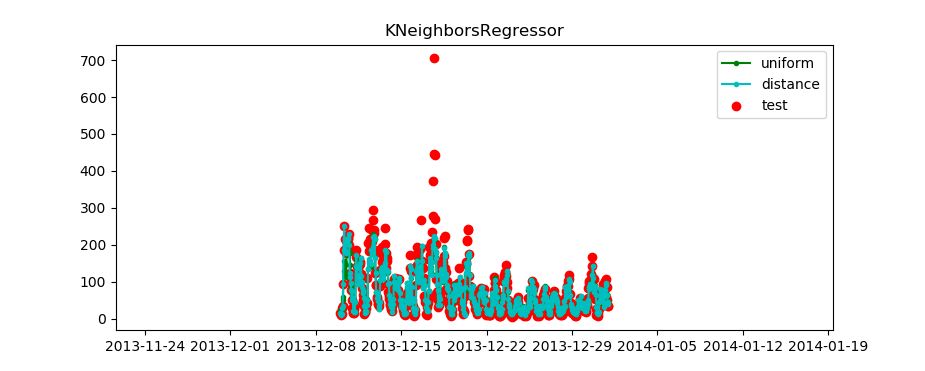

uniform mae: 21.95530806451613	mse: 1537.3025213810483
distance mae: 20.487072679411142	mse: 1445.0074500680946


In [80]:
# plt.figure(figsize=(20,10))
# #############################################################################
# Fit regression model
n_neighbors = 10

plt.figure(figsize=(9, 4))
#plt.scatter(index_train, y_train, c='k', label='train')
plt.scatter(index_test, y_test, c='r', label='test')

colors = ['g', 'c', 'y', 'orange', 'b']
solutions = {}

for i, weights in enumerate(['uniform', 'distance']):
    knn = neighbors.KNeighborsRegressor(n_neighbors, weights=weights)
    knn_model = knn.fit(x_train, y_train)
    y_ = knn_model.predict(x_test)
    solutions['knn %s' % weights] = y_

    plt.plot(index_test, y_, '.-', c=colors[i], label=weights)
    plt.axis('tight')
    plt.legend()
    plt.title("KNeighborsRegressor")
    print('{0} mae: {1}\tmse: {2}'.format(weights, 
                                          metrics.mean_absolute_error(y_test, y_),
                                          metrics.mean_squared_error(y_test, y_)))

<IPython.core.display.Javascript object>


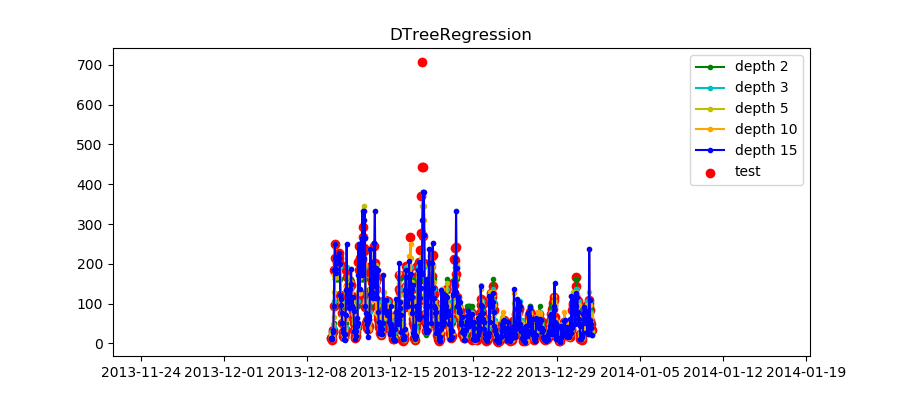

2 mae: 24.376921168547387	mse: 1919.0991674122224
3 mae: 21.59751982206249	mse: 1605.794062995328
5 mae: 21.040849065058826	mse: 1280.9156862774573
10 mae: 25.122869829076063	mse: 1860.6728110212462
15 mae: 25.169404998754224	mse: 1916.5976860697922


In [83]:
plt.figure(figsize=(9, 4))
#plt.scatter(index_train, y_train, c='k', label='train')
plt.scatter(index_test, y_test, c='r', label='test')

colors = ['g', 'c', 'y', 'orange', 'b']

########################################################################
for i, depth in enumerate([2, 3, 5, 10, 15]):
    dtree = tree.DecisionTreeRegressor(max_depth=depth)
    dtree_model = dtree.fit(x_train, y_train)
    y_ = dtree_model.predict(x_test)
    solutions['dtree depth %s' % depth] = y_

    plt.plot(index_test, y_, '.-', c=colors[i], label='depth {0}'.format(depth))
    plt.axis('tight')
    plt.legend()
    plt.title("DTreeRegression")
    print('{0} mae: {1}\tmse: {2}'.format(depth, 
                                          metrics.mean_absolute_error(y_test, y_),
                                          metrics.mean_squared_error(y_test, y_)))

<IPython.core.display.Javascript object>


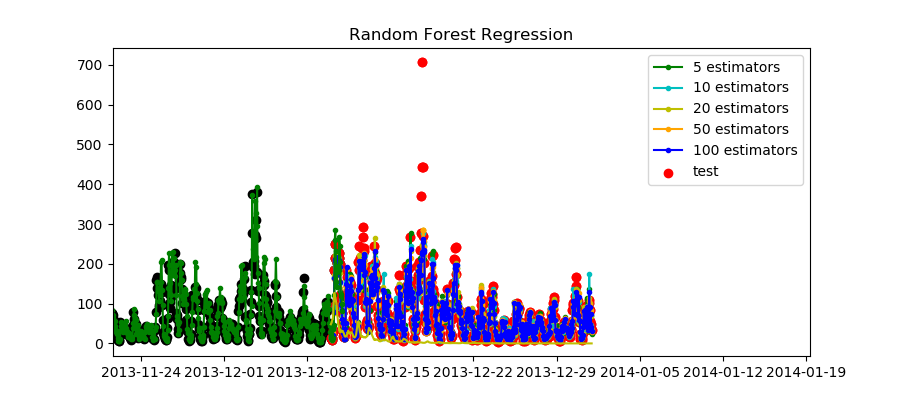

5 mae: 22.25477495256167	mse: 1734.9241300426563
10 mae: 21.474829222011387	mse: 1582.8250027487381
20 mae: 20.386324146110056	mse: 1330.7075338513337
50 mae: 20.428000474383296	mse: 1394.5591030203202
100 mae: 20.30226828273244	mse: 1368.5874538520031


In [86]:
plt.figure(figsize=(9, 4))
#plt.scatter(index_train, y_train, c='k', label='train')
plt.scatter(index_test, y_test, c='r', label='test')

colors = ['g', 'c', 'y', 'orange', 'b']

########################################################################
for i, estimators in enumerate([5, 10, 20, 50, 100]):
    rforest = ensemble.RandomForestRegressor(n_estimators=estimators)
    rforest_model = rforest.fit(x_train, y_train)
    y_ = rforest_model.predict(x_test)
    solutions['rforest estimators {0}'.format(estimators)] = y_

    plt.plot(index_test, y_, '.-', c=colors[i], label='{0} estimators'.format(estimators))
    plt.axis('tight')
    plt.legend()
    plt.title('Random Forest Regression')
    print('{0} mae: {1}\tmse: {2}'.format(estimators, 
                                          metrics.mean_absolute_error(y_test, y_),
                                          metrics.mean_squared_error(y_test, y_)))

In [ ]:
## not yet working or running way, way, way too long

arima = ARIMA(df.loc['DESN025'].Concentration.NO, order=(25,1,0))
arima_model = arima.fit(disp=0)
print(arima_model.summary())
# plot residual errors
residuals = DataFrame(arima_model.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

D:\Program Files\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Program Files\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


<IPython.core.display.Javascript object>


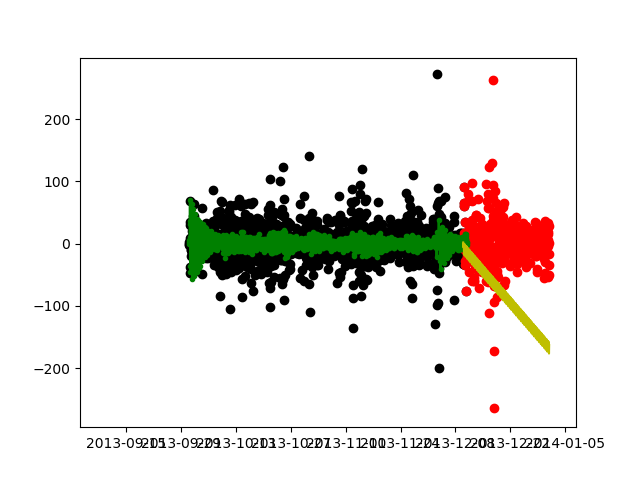

mae: 87.83191004852914
{'smoothing_level': 0.05263157894736842, 'smoothing_slope': 0.05263157894736842, 'smoothing_seasonal': 0.10526315789473684, 'damping_slope': nan, 'initial_level': 0.0, 'initial_slope': 0.0, 'initial_seasons': array([  2.7744152,  -0.1505848,   5.6124152,  11.0074152,  37.0394152,
        70.7444152,  32.7114152, -45.2245848, -34.1485848,   2.1634152]), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


In [21]:
ets = ExponentialSmoothing(y_train_diff, trend='add', seasonal='add', seasonal_periods=int(len(y_train)/(7*24)))
ets_model = ets.fit(optimized=True)
ets_forecast = ets_model.forecast(len(y_test))

plt.scatter(index_train, y_train_diff, c='k', label='train')
plt.scatter(index_test, y_test_diff, c='r', label='test')
plt.plot(index_train, ets_model.fittedvalues, '.-', c='g', label='fit')
plt.plot(index_test, ets_forecast, c='y', label='forecast')

print('mae: {}'.format(metrics.mean_absolute_error(y_test_diff, ets_forecast)))
print(ets_model.params)

<IPython.core.display.Javascript object>


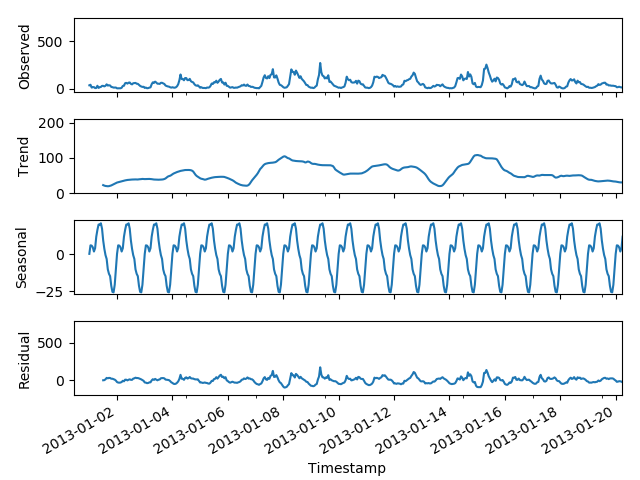

In [73]:
decompfreq = 24
decomposition = seasonal_decompose(df.loc['DESN025'].Concentration.NO, freq=decompfreq, model='additive').plot()